In [1]:
import sys

#!{sys.executable} -m pip install -r ../requirements-dev.txt  # to install the orchestrator package
#!{sys.executable} -m pip install -U ../.  # to install the orchestra
#!{sys.executable} -m pip uninstall huggingface-hub --yes
#!{sys.executable} -m pip uninstall transformers --yes
#!{sys.executable} -m pip install huggingface-hub==0.30.0
#!{sys.executable} -m pip install transformers --upgrade
#!{sys.executable} -m pip install huggingface-hub==0.21.4
#!{sys.executable} -m pip install transformers==4.40.2
#!{sys.executable} -m pip install sentence-transformers==2.2.2

#!{sys.executable} -m pip install -r ../david_reqs.txt

In [16]:

# %pip install ipywidgets --upgrade
# %pip install -r ../requirements-dev.txt  # to install the orchestrator package
# %pip install -U ../.  # to install the orchestra
# tor package

In [1]:
import os
from pathlib import Path
import sys
base_path = Path(os.path.abspath("")).parent
sys.path.append(base_path.as_posix())
base_path.as_posix()

'/Users/id05358/Documents/Project/FLUIDOS/fluidos-modelbased-metaorchestrator'

In [2]:
import logging
import random
import shutil
from pathlib import Path
from typing import Any
import os

import numpy as np  # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf  # type: ignore
import torch  # type: ignore
import matplotlib.pyplot as plt

from fluidos_model_orchestrator.data_pipeline.augmentation.augmentation_utils import AUGMENTATION_TYPES
from fluidos_model_orchestrator.data_pipeline.data_util import FLUIDOS_DATASETS
from fluidos_model_orchestrator.data_pipeline.data_util import get_target_column
from fluidos_model_orchestrator.data_pipeline.data_util import load_ml_ready_df
from fluidos_model_orchestrator.model.utils import MODEL_TYPES
from fluidos_model_orchestrator.model_pipeline.model_trainer_factory import ModelTrainerFactory
from fluidos_model_orchestrator.model.utils import FLUIDOS_COL_NAMES

import ipywidgets as widgets
widgets.IntSlider()

tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

## Hyperparameters

In [3]:
ROOT_DIR = Path(os.getcwd()).parent.parent

platform = "ccc"  # "local"
dataset_name = FLUIDOS_DATASETS.BITBRAINS  # FLUIDOS_DATASETS.GCT
model_type = MODEL_TYPES.CG  # MODEL_TYPES.FLUIDOS_RANKER
augmentation = AUGMENTATION_TYPES.FEEDBACK_LOOP  # AUGMENTATION_TYPES.PERFORMANCE_RATING

epochs = 2
load_from_generated = True ## Change if first time executing
test_mode = False
max_pod = 2000
tr_number = 50 # -1 for gct

path_output_model = "./"
path_output = "./"

dataset_subset = "rnd"

#DATASETS can be downloaded here: https://drive.google.com/drive/folders/13sNpT5ycd7XHPFcpEHEVQ1RtctMQADcK
path_dataset_ml_ready = "/Users/id05358/Documents/Project/FLUIDOS/ibm_telefonica_dataset"
# path_dataset_ml_ready = "<INSERT_YOUR_PATH_HERE>/ibm_telefonica_dataset"

MODEL_GLOBAL = "model_global"
MODEL_GLOBAL_UPDATED = "model_global_updated"
MODEL_GLOBAL_UPDATED_DP = "model_global_updated_DP"
FED_MODELS_TRAINED = [MODEL_GLOBAL, "model_B", "model_C"]

In [4]:
def split_dataset(df: pd.DataFrame, model_names: list[str], model_source_name: str, train_ratio: float = 0.2, test_ratio: float = 0.05) -> dict[str, dict[str, Any]]:

    manifests = df[[FLUIDOS_COL_NAMES.POD_FILE_NAME, FLUIDOS_COL_NAMES.POD_MANIFEST]]
    counts = manifests[FLUIDOS_COL_NAMES.POD_MANIFEST].value_counts().to_dict()
    # Estimation of pod manifests distribution
    frequency_per_pod = []
    for index, row in manifests.iterrows():
        frequency_per_pod.append(counts[row[FLUIDOS_COL_NAMES.POD_MANIFEST]])

    manifests.insert(2, "frequency", frequency_per_pod)
    manifests = manifests.sort_values(by="frequency", ascending=False)
    manifests["frequency"] = manifests["frequency"] / len(manifests)
    manifests.index = range(len(manifests.index))
    manifests = manifests.reset_index()

    manifests_size = len(manifests)

    train_size = int(train_ratio * manifests_size)
    test_size = int(test_ratio * manifests_size) 
    test_manifests = manifests.sample(test_size)

    train_manifests = manifests[:train_size]
    local_manifests = manifests[train_size:]

    train_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(train_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    local_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(local_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    test_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(test_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    split_size = len(local_pods) // (len(model_names) - 1)
    local_pods_chunks = [local_pods[i:i + split_size] for i in range(0, len(local_pods), split_size)]

    model_attributes = {}
    model_attributes[MODEL_GLOBAL] = {"df_train": train_pods, "df_test": test_pods}
    for index, model_name in enumerate(model_names[1:]):
        model_attributes[model_name] = {"df_train": local_pods_chunks[index],
                                        "df_test": test_pods}
            
    return model_attributes

## Preparing Datasets

In [5]:
logging.info("Starting Model Building and Training")

ml_ready_dataset_path = Path(path_dataset_ml_ready)

pods_assigment_df, template_resources_df = load_ml_ready_df(ml_ready_dataset_path)

#TODO TMP - remove this when all tested 
# pods_assigment_df = pods_assigment_df[:10000]

model_attributes = split_dataset(pods_assigment_df, FED_MODELS_TRAINED, MODEL_GLOBAL)

Loading dataset: /Users/id05358/Documents/Project/FLUIDOS/ibm_telefonica_dataset


## Setting up model Trainers

In [6]:
# Time-consuming step for the first run, if run for the second time set load_from_generated=True at the beginning of the notebook
if dataset_name == FLUIDOS_DATASETS.BITBRAINS:
    total_pods = max_pod * tr_number
else:
    total_pods = max_pod
    
for model_name in FED_MODELS_TRAINED:
    model_trainer = ModelTrainerFactory.create_model_trainer(model_type,
                                                             ml_ready_dataset_path,
                                                             Path(path_output).joinpath("model_training"),
                                                             max_pod=total_pods,
                                                             epochs=epochs,
                                                             target_column=get_target_column(augmentation),
                                                             load_from_generated=load_from_generated,
                                                             model_name=model_name)
    model_trainer.prepare_directories()
    model_attributes[model_name]["trainer"] = model_trainer

for model_name in FED_MODELS_TRAINED:
    TRAINING_RATIO = 1.0
    cached_train = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_train'],
                                                                           template_resources_df, test_mode,
                                                                           training_size_ratio=TRAINING_RATIO,
                                                                           model_tag=model_name, dataset_type="train")
    cached_test = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_test'],
                                                                          template_resources_df, test_mode,
                                                                          training_size_ratio=TRAINING_RATIO,
                                                                          model_tag=model_name, dataset_type="test")
    model_attributes[model_name]["trainer"].cached_train = cached_train
    model_attributes[model_name]["trainer"].cached_test = cached_test

Creating model trainer
Preparing directories
Creating model trainer
Preparing directories
Creating model trainer
Preparing directories


## Training Global model

In [7]:
model_attributes[MODEL_GLOBAL]["trainer"].build_model()
model_attributes[MODEL_GLOBAL]["trainer"].check_model_dataset_depencies()
model_attributes[MODEL_GLOBAL]["trainer"].train_model()
model_attributes[MODEL_GLOBAL]["eval_results"] = model_attributes[MODEL_GLOBAL]["trainer"].evaluate()

for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_GLOBAL:
        continue
    shutil.copytree(model_attributes[MODEL_GLOBAL]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[model_name]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)

Training...


Epoch 0: 100%|██████████| 2500/2500 [00:11<00:00, 213.44batch/s, accuracy=1, loss=2.95]   


Epoch 0, train loss 3.1008 Accuracy 0.88 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/643 [00:00<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 0, val loss 3.445 Accuracy 0.5
Current minimal val loss is 3.444971208438903.


Epoch 1: 100%|██████████| 2500/2500 [00:10<00:00, 230.87batch/s, accuracy=0.75, loss=3.19]


Epoch 1, train loss 2.9879 Accuracy 0.96 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/643 [00:00<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 1, val loss 3.3944 Accuracy 0.55
Current minimal val loss is 3.394439204855247.
("Evaluation results: {'total_loss': 3.394439204855247, 'accuracy': "
 '0.5472395023328149}')


## Training Child Models from Global Model

In [8]:
for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_GLOBAL:
        continue
    print(model_name)
    model_attributes[model_name]["trainer"].load_model(load_from_checkpoint=True)  # type: ignore
    model_attributes[model_name]["trainer"].train_model()
    model_attributes[model_name]["eval_results"] = model_attributes[model_name]["trainer"].evaluate()

logging.info("MODELS Evaluation Results")
for model_name in FED_MODELS_TRAINED:
    if "eval_results" in model_attributes[model_name]:
        logging.info(f"MODEL: {model_name}: {model_attributes[model_name]['eval_results']}")

logging.info(f"Pipeline output located at: {path_output_model}")


model_B
Training...


Epoch 0: 100%|██████████| 5000/5000 [00:19<00:00, 262.88batch/s, accuracy=0.75, loss=3.2] 


Epoch 0, train loss 3.2561 Accuracy 0.69 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/643 [00:00<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 0, val loss 3.1404 Accuracy 0.8
Current minimal val loss is 3.140428249053599.


Epoch 1: 100%|██████████| 5000/5000 [00:19<00:00, 260.19batch/s, accuracy=0.62, loss=3.32]


Epoch 1, train loss 3.2124 Accuracy 0.73 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/643 [00:01<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 1, val loss 3.1281 Accuracy 0.82
Current minimal val loss is 3.1281125864381925.
("Evaluation results: {'total_loss': 3.1281125864381925, 'accuracy': "
 '0.8172628304821151}')
model_C
Training...


Epoch 0: 100%|██████████| 5000/5000 [00:24<00:00, 202.60batch/s, accuracy=1, loss=2.95]   


Epoch 0, train loss 3.2204 Accuracy 0.73 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/643 [00:01<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 0, val loss 3.1772 Accuracy 0.77
Current minimal val loss is 3.1771794933924222.


Epoch 1: 100%|██████████| 5000/5000 [00:22<00:00, 226.08batch/s, accuracy=0.88, loss=3.07]


Epoch 1, train loss 3.1578 Accuracy 0.79 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/643 [00:01<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 1, val loss 3.1682 Accuracy 0.78
Current minimal val loss is 3.168161239816835.
("Evaluation results: {'total_loss': 3.168161239816835, 'accuracy': "
 '0.7776049766718507}')


## Federated Learning POC

Idea: send averaged updates from model_B(Mb) and model_C(Mc) to update the model_global (Ms -> Ms').

In [9]:
FED_MODELS_TRAINED.append(MODEL_GLOBAL_UPDATED)

In [10]:
# Generation of averaged local model updates
model_source_weights = model_attributes[MODEL_GLOBAL]["trainer"].orchestrator.state_dict().values()
model_B_weights = model_attributes['model_B']["trainer"].orchestrator.state_dict().values()
model_C_weights = model_attributes['model_C']["trainer"].orchestrator.state_dict().values()

model_b_s_update = [(x - y) for x, y in zip(model_B_weights, model_source_weights)]
model_c_s_update = [(x - y) for x, y in zip(model_C_weights, model_source_weights)]

## ADD DP to differences wrt GLOBAL MODEL

averaged_update = [0.5*(x + y) for x, y in zip(model_b_s_update, model_c_s_update)]
# updated weights: Ms’ = Ms + 0.5*((Ms-Mb) + (Ms-Mc))
model_global_weights = [x + y for x, y in zip(averaged_update, model_source_weights)]


In [11]:
# Creation of the Global model object
model_attributes[MODEL_GLOBAL_UPDATED] = {}
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"] = ModelTrainerFactory.create_model_trainer(model_type,
                                                                                             ml_ready_dataset_path,
                                                                                             Path(path_output).joinpath("model_training"),
                                                                                             max_pod=total_pods,
                                                                                             epochs=epochs,
                                                                                             target_column=get_target_column(augmentation),
                                                                                             load_from_generated=True,
                                                                                             model_name=MODEL_GLOBAL_UPDATED)
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].prepare_directories()
model_attributes[MODEL_GLOBAL_UPDATED]["df_train"] = model_attributes[MODEL_GLOBAL]["df_train"].copy()
model_attributes[MODEL_GLOBAL_UPDATED]["df_test"] = model_attributes[MODEL_GLOBAL]["df_test"].copy()
shutil.copytree(model_attributes[MODEL_GLOBAL]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)

TRAINING_RATIO = 1.0
cached_train = model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].prepare_dataset(model_attributes[MODEL_GLOBAL_UPDATED]['df_train'],
                                                                                 template_resources_df, test_mode,
                                                                                 training_size_ratio=TRAINING_RATIO,
                                                                                 model_tag=MODEL_GLOBAL, dataset_type="train")
cached_test = model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].prepare_dataset(model_attributes[MODEL_GLOBAL_UPDATED]['df_test'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=MODEL_GLOBAL, dataset_type="test")
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].cached_train = cached_train
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].cached_test = cached_test
    
    
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].build_model()

Creating model trainer
Preparing directories


OrchestrationModel(
  (config_embedding): Embedding(50, 8)
  (config_embedding_dropout): Dropout(p=0.2, inplace=False)
  (pod_embedding): Embedding(119547, 512)
  (embedding_aggregator): EmbeddingAggregation()
  (linear1): Linear(in_features=528, out_features=1024, bias=True)
  (activation1): ReLU(inplace=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (fc_layer1): Sequential(
    (0): Linear(in_features=528, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
  )
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (activation2): ReLU(inplace=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc_layer2): Sequential(
    (0): Linear(in_

In [12]:
# load the updated model weights Ms' and evaluate the model with the common test subset
from collections import OrderedDict

model_global_weights_dict = {}
index = 0
for key in model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].orchestrator.state_dict():
    model_global_weights_dict[key] = model_global_weights[index]
    index += 1
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].orchestrator.load_state_dict(OrderedDict(model_global_weights_dict))    
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].orchestrator.eval()

model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].validate_model()
model_attributes[MODEL_GLOBAL_UPDATED]["eval_results"] = model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].evaluate()

(val) Epoch 0:   0%|          | 0/643 [00:01<?, ?batch/s, v_accuracy=0.5, val_loss=3.44] 


("Evaluation results: {'total_loss': 3.154359614311444, 'accuracy': "
 '0.7927682737169518}')


## Evaluation

In [13]:
if model_type == MODEL_TYPES.CG:
    results_df = pd.DataFrame(index=['accuracy', 'total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value
elif MODEL_TYPES.FLUIDOS_RANKER:
    results_df = pd.DataFrame(index=['root_mean_squared_error','loss','regularization_loss','total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value

results_df

,model_global,model_B,model_C,model_global_updated
accuracy,0.54724,0.817263,0.777605,0.792768
total_loss,3.394439,3.128113,3.168161,3.15436


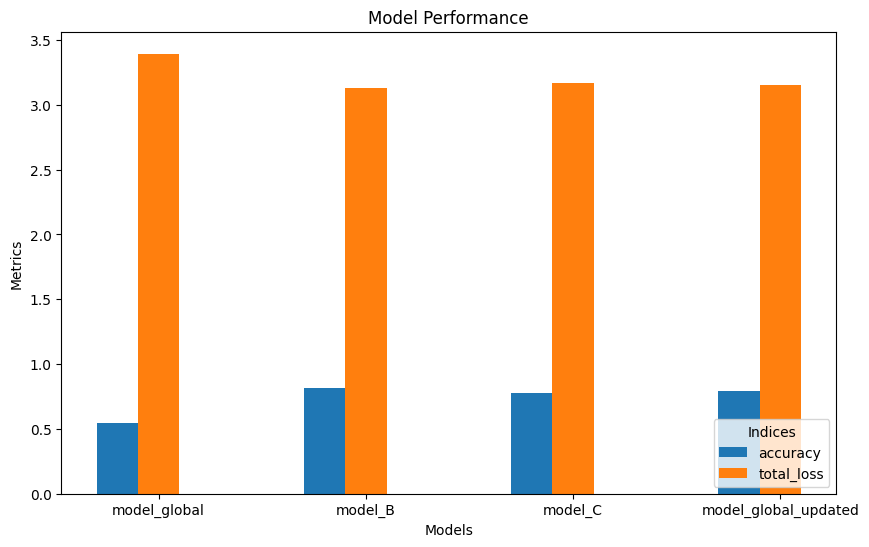

In [14]:
%matplotlib inline


plt.figure(figsize=(10, 6))



bar_width = 0.2
bar_positions = np.arange(len(results_df.columns))


for i, index in enumerate(results_df.index):
    plt.bar(
        bar_positions + i * bar_width,
        results_df.loc[index],
        width=bar_width,
        label=index
    )

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance')
plt.xticks(bar_positions + bar_width, results_df.columns)
plt.legend(title='Indices', loc='lower right')

plt.show()


## Adding Central DP

### 1. Defining DP functions

In [15]:
from functools import reduce
import numpy as np
from numpy.typing import NDArray
from opacus.accountants.utils import get_noise_multiplier
from typing import List

In [16]:
def clip_inputs_inplace(model_updates: List[List[torch.Tensor]], clipping_norm: float, noise_type: str) -> None:
    """
    In-place norm clipping for a list of client updates. Each client update is a list of PyTorch tensors.

    Args:
        model_updates: list of client updates, each a list of PyTorch tensors.
        clipping_norm: norm bound to clip each client update to.
        noise_type: 'gaussian' uses L2 norm, 'laplace' uses L1 norm.
    """
    if noise_type == 'gaussian':
        lp_norm = 2
    elif noise_type == 'laplace':
        lp_norm = 1
    else:
        raise ValueError(f'noise_type {noise_type} not supported!')

    for i, update in enumerate(model_updates):
        # Cast layers to float just for norm calculation
        norm = sum(torch.norm(layer.float().view(-1), p=lp_norm).item() ** lp_norm for layer in update) ** (1 / lp_norm)

        print(f"Client {i} original norm: {norm:.4f}")

        if norm > clipping_norm and norm > 0:
            scaling_factor = clipping_norm / norm
            print(f"Scaling client {i} by factor: {scaling_factor:.4f}")
            for j, layer in enumerate(update):
                if not torch.is_floating_point(layer):
                    layer = layer.float()
                    update[j] = layer  # update reference
                update[j].mul_(scaling_factor)
        else:
            print(f"Client {i} not clipped.")


In [17]:
def add_noise(
    params: List[torch.Tensor],
    std_dev: float,
    noise_type: str,
    layer_names: List[str]
) -> List[torch.Tensor]:
    """
    Add DP noise to a list of tensors, skipping sensitive layers.
    """
    skip_keywords = ["running_mean", "running_var", "num_batches_tracked", "bias", "embedding.weight", "pod_embedding.weight"]
    noisy_params = []

    for name, param in zip(layer_names, params):
        if any(skip in name for skip in skip_keywords):
            noisy_params.append(param)
            continue

        if not torch.is_floating_point(param):
            param = param.float()

        if noise_type == 'gaussian':
            noise = torch.normal(mean=0.0, std=std_dev, size=param.shape).to(param.device)
        elif noise_type == 'laplace':
            noise = torch.from_numpy(np.random.laplace(loc=0.0, scale=std_dev, size=param.shape)).float().to(param.device)
        else:
            raise ValueError(f"Unsupported noise type: {noise_type}")

        noisy_params.append(param + noise)

    return noisy_params


def privacy_accountant(target_epsilon: float, target_delta: float, fl_rounds: int = 1, sampling_frac: float = 1,
                       noise_type: str = 'gaussian', max_alpha: int = 128) -> float:
    """
    Privacy accounting to change from (epsilon, delta) to noise sigma, wraps Opacus for ADP.
    Args:
        target_epsilon: DP epsilon
        target_delta: DP delta, should be 0 for pure DP (laplace noise).
        fl_rounds: total number of FL rounds
        sampling_frac: probability of including a given client in an FL round (Poisson sampling with constant probability); this does not affect pure DP (delta=0), which should have sampling_frac == 1 in accounting.
        noise_type: type of noise to be used, supports 'gaussian' or 'laplace'; gaussian noise uses RDP accounting from Opacus, Laplace assumes pure DP
        max_alpha: maximum value of alpha to be used in RDP accounting; try increasing this is if encountering errors from RDP accountant, larger value can be more accurate, but also slower
    Returns:
        noise_sigma: DP noise parameter
    """
    assert target_epsilon > 0, f'target epsilon must be > 0, got {target_epsilon}'
    assert 0 <= target_delta <= 1, f'target delta must be in [0,1], got {target_delta}'
    assert fl_rounds > 0, f'FL rounds must be > 0, got {fl_rounds}'
    assert 0 < sampling_frac <= 1, f'sampling frac must be in [0,1], got {sampling_frac}'

    if noise_type == 'gaussian':
        # use RDP accountant from Opacus with Poisson subsampling on the clients
        # assume sensitivity = 1 and rescale in dp_module when doing clipping
        alphas = [1 + x / 100.0 for x in range(1, 100)] + [1.5 + x / 10.0 for x in range(0, 50)] + list(range(12, max_alpha))
        noise_sigma = get_noise_multiplier(target_epsilon=target_epsilon, target_delta=target_delta, steps=fl_rounds,
                                           sample_rate=sampling_frac, accountant='rdp', alphas=alphas)

    elif noise_type == 'laplace':
        assert target_delta == 0, f'Got delta != 0 with laplace noise. Pure DP with laplace noise has delta == 0!'
        assert sampling_frac == 1., f'Got sampling fraction != 1 with laplace noise. Pure DP with laplace noise does NOT benefit from subsampling!'
        # noise_sigma for laplace: for each step, scale = sensitivity/(eps/n_comps); here assume sensitivity = 1 and rescale in dp_module when doing clipping
        noise_sigma = fl_rounds / target_epsilon
    else:
        raise ValueError(f'noise_type {noise_type} not supported!')

    return noise_sigma

### 2. Clipping the updates

In [18]:
model_b_s_update = [(torch.Tensor(x) - y) for x, y in zip(model_B_weights, model_source_weights)]
model_c_s_update = [(torch.Tensor(x) - y) for x, y in zip(model_C_weights, model_source_weights)]

In [19]:
# won't affect a lot on the performance
clipping_norm = 10.5

In [20]:
clip_inputs_inplace([model_b_s_update],clipping_norm=clipping_norm, noise_type='gaussian')
clip_inputs_inplace([model_c_s_update],clipping_norm=clipping_norm, noise_type='gaussian')

Client 0 original norm: 12.6363
Scaling client 0 by factor: 0.8309
Client 0 original norm: 12.2634
Scaling client 0 by factor: 0.8562


In [21]:
averaged_update = [0.5 * (x + y) for x, y in zip(model_b_s_update, model_c_s_update)]
# updated weights: Ms’ = Ms + 0.5*((Ms-Mb) + (Ms-Mc))
model_global_weights = [x + y for x, y in zip(averaged_update, model_source_weights)]

In [22]:
flat_weights = torch.cat([w.view(-1) for w in model_global_weights])
print(f"Before noise: mean={flat_weights.mean().item():.4f}, std={flat_weights.std().item():.4f}, max={flat_weights.max().item():.4f}")

Before noise: mean=0.0004, std=1.2428, max=2500.0000


In [29]:
expected_keys = list(model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].orchestrator.state_dict().keys())

# 🔍 Inspect the model layers before adding noise
for i, (k, w) in enumerate(zip(expected_keys, model_global_weights)):
    print(f"{i:02d} - {k:40s} | shape: {w.shape} | mean={w.mean().item():.4f}, std={w.std().item():.4f}, max={w.max().item():.4f}")


00 - config_embedding.weight                  | shape: torch.Size([50, 8]) | mean=0.0436, std=0.9872, max=2.2275
01 - pod_embedding.weight                     | shape: torch.Size([119547, 512]) | mean=0.0001, std=1.0000, max=5.3342
02 - linear1.weight                           | shape: torch.Size([1024, 528]) | mean=0.0000, std=0.0259, max=0.1246
03 - linear1.bias                             | shape: torch.Size([1024]) | mean=0.0012, std=0.0253, max=0.1198
04 - batch_norm1.weight                       | shape: torch.Size([1024]) | mean=1.0000, std=0.0128, max=1.0477
05 - batch_norm1.bias                         | shape: torch.Size([1024]) | mean=0.0007, std=0.0066, max=0.0448
06 - batch_norm1.running_mean                 | shape: torch.Size([1024]) | mean=0.0299, std=0.0302, max=0.1465
07 - batch_norm1.running_var                  | shape: torch.Size([1024]) | mean=0.0003, std=0.0003, max=0.0018
08 - batch_norm1.num_batches_tracked          | shape: torch.Size([]) | mean=2500.0000, std

These layers are not meant to be noised:
- running_mean, running_var, num_batches_tracked: internal BatchNorm buffers – not trainable
- bias: very small scale – adding noise easily destabilizes them
- embedding.weight, pod_embedding.weight: huge size and sensitive — even small noise causes loss to diverge

In [24]:
skip_keywords = [
    "running_mean", "running_var", "num_batches_tracked",  # BatchNorm internals
    "bias",                                                # Biases across layers
    "embedding.weight", "pod_embedding.weight"             # Embeddings
]

### 3. Adding noise to aggregated weights

In [25]:
EPSILON = 100
DELTA = 1e-5

noise_sigma = privacy_accountant(EPSILON,DELTA)
print(f"Computed noise sigma: {noise_sigma}")

Computed noise sigma: 0.09740352630615234


In [30]:
expected_keys = list(model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].orchestrator.state_dict().keys())

In [31]:
model_global_weights_prime = add_noise(
    params=model_global_weights,
    std_dev= noise_sigma/3,  # scale per 3 clients
    noise_type='gaussian',
    layer_names=expected_keys
)

In [33]:
# Clean any NaNs/Infs introduced by noise
for i, w in enumerate(model_global_weights_prime):
    w = torch.nan_to_num(w, nan=0.0, posinf=1.0, neginf=-1.0)
    model_global_weights_prime[i] = w

In [34]:
flat_noisy = torch.cat([w.view(-1) for w in model_global_weights_prime])
print(f"After noise: mean={flat_noisy.mean().item():.4f}, std={flat_noisy.std().item():.4f}, max={flat_noisy.max().item():.4f}")

After noise: mean=0.0004, std=1.2429, max=2500.0000


### 4. Federated Learning POC

In [35]:
FED_MODELS_TRAINED.append(MODEL_GLOBAL_UPDATED_DP)

In [36]:
# Creation of the Global model object
model_attributes[MODEL_GLOBAL_UPDATED_DP] = {}
model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"] = ModelTrainerFactory.create_model_trainer(model_type,
                                                                                             ml_ready_dataset_path,
                                                                                             Path(path_output).joinpath("model_training"),
                                                                                             max_pod=total_pods,
                                                                                             epochs=epochs,
                                                                                             target_column=get_target_column(augmentation),
                                                                                             load_from_generated=True,
                                                                                             model_name=MODEL_GLOBAL_UPDATED_DP)
model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].prepare_directories()
model_attributes[MODEL_GLOBAL_UPDATED_DP]["df_train"] = model_attributes[MODEL_GLOBAL]["df_train"].copy()
model_attributes[MODEL_GLOBAL_UPDATED_DP]["df_test"] = model_attributes[MODEL_GLOBAL]["df_test"].copy()
shutil.copytree(model_attributes[MODEL_GLOBAL]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)

TRAINING_RATIO = 1.0
cached_train = model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].prepare_dataset(model_attributes[MODEL_GLOBAL_UPDATED_DP]['df_train'],
                                                                                 template_resources_df, test_mode,
                                                                                 training_size_ratio=TRAINING_RATIO,
                                                                                 model_tag=MODEL_GLOBAL, dataset_type="train")
cached_test = model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].prepare_dataset(model_attributes[MODEL_GLOBAL_UPDATED_DP]['df_test'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=MODEL_GLOBAL, dataset_type="test")
model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].cached_train = cached_train
model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].cached_test = cached_test


model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].build_model()


Creating model trainer
Preparing directories


OrchestrationModel(
  (config_embedding): Embedding(50, 8)
  (config_embedding_dropout): Dropout(p=0.2, inplace=False)
  (pod_embedding): Embedding(119547, 512)
  (embedding_aggregator): EmbeddingAggregation()
  (linear1): Linear(in_features=528, out_features=1024, bias=True)
  (activation1): ReLU(inplace=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (fc_layer1): Sequential(
    (0): Linear(in_features=528, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
  )
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (activation2): ReLU(inplace=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc_layer2): Sequential(
    (0): Linear(in_

### 5. Performance evaluation

In [38]:
# load the updated model weights Ms' and evaluate the model with the common test subset
from collections import OrderedDict

# Unwrap the DP-weighted model (only one "client" in the list)
dp_weights = model_global_weights_prime

# Sanity check
expected_keys = list(model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].orchestrator.state_dict().keys())
assert len(expected_keys) == len(dp_weights), f"Expected {len(expected_keys)} layers, got {len(dp_weights)}"

# Construct state_dict from DP weights
model_global_weights_prime_dict = {
    k: v.clone().detach().to(model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].orchestrator.state_dict()[k].device)
    for k, v in zip(expected_keys, dp_weights)
}

# Load updated DP model
model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].orchestrator.load_state_dict(OrderedDict(model_global_weights_prime_dict))
model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].orchestrator.eval()

model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].validate_model()
model_attributes[MODEL_GLOBAL_UPDATED_DP]["eval_results"] = model_attributes[MODEL_GLOBAL_UPDATED_DP]["trainer"].evaluate()


if model_type == MODEL_TYPES.CG:
    results_df = pd.DataFrame(index=['accuracy', 'total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value
elif MODEL_TYPES.FLUIDOS_RANKER:
    results_df = pd.DataFrame(index=['root_mean_squared_error','loss','regularization_loss','total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value

results_df

(val) Epoch 0:   0%|          | 0/643 [00:00<?, ?batch/s, v_accuracy=0.5, val_loss=3.45] 


("Evaluation results: {'total_loss': 3.2607388210889896, 'accuracy': "
 '0.7017884914463453}')


,model_global,model_B,model_C,model_global_updated,model_global_updated_DP
accuracy,0.54724,0.817263,0.777605,0.792768,0.701788
total_loss,3.394439,3.128113,3.168161,3.15436,3.260739


### 6. Plotting results

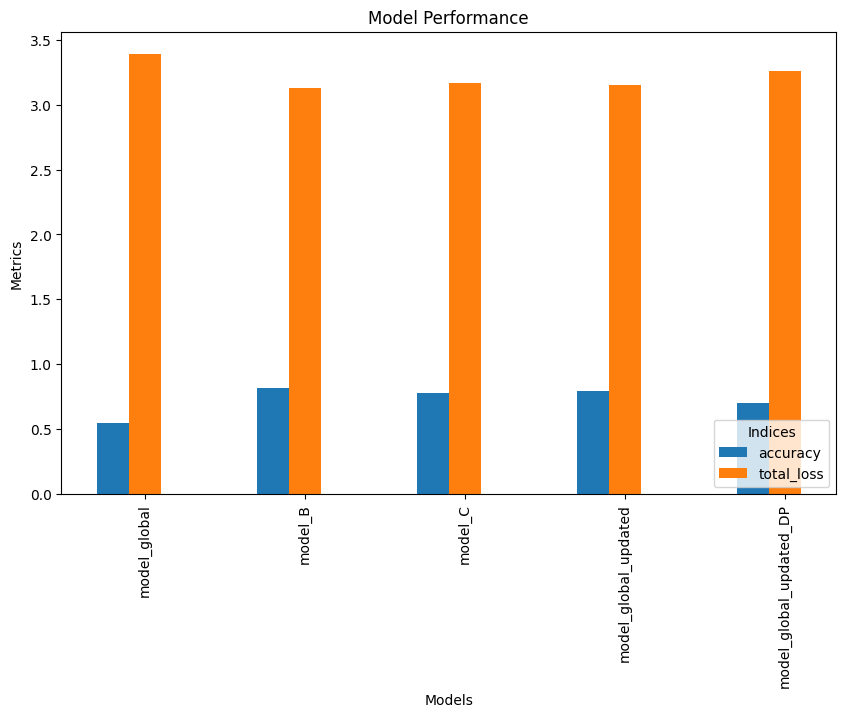

In [39]:
%matplotlib inline


plt.figure(figsize=(10, 6))

bar_width = 0.2
bar_positions = np.arange(len(results_df.columns))


for i, index in enumerate(results_df.index):
    plt.bar(
        bar_positions + i * bar_width,
        results_df.loc[index],
        width=bar_width,
        label=index
    )

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance')
plt.xticks(bar_positions + bar_width, results_df.columns, rotation='vertical')
plt.legend(title='Indices', loc='lower right')

plt.show()
